## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

In [4]:
# Check the shape
df.shape

(167, 10)

In [5]:
# Check datatypes & counts
#df.dtype would give data types only, as count is wanted .info is more siccinct 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
# Identify any missing data
missing = df.isnull()
mvc = missing.sum()
print(mvc)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [8]:
# Drop any non-numeric features (columns)

#Float and int can stay, object to go
df= df.drop(columns=['country'])

df.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

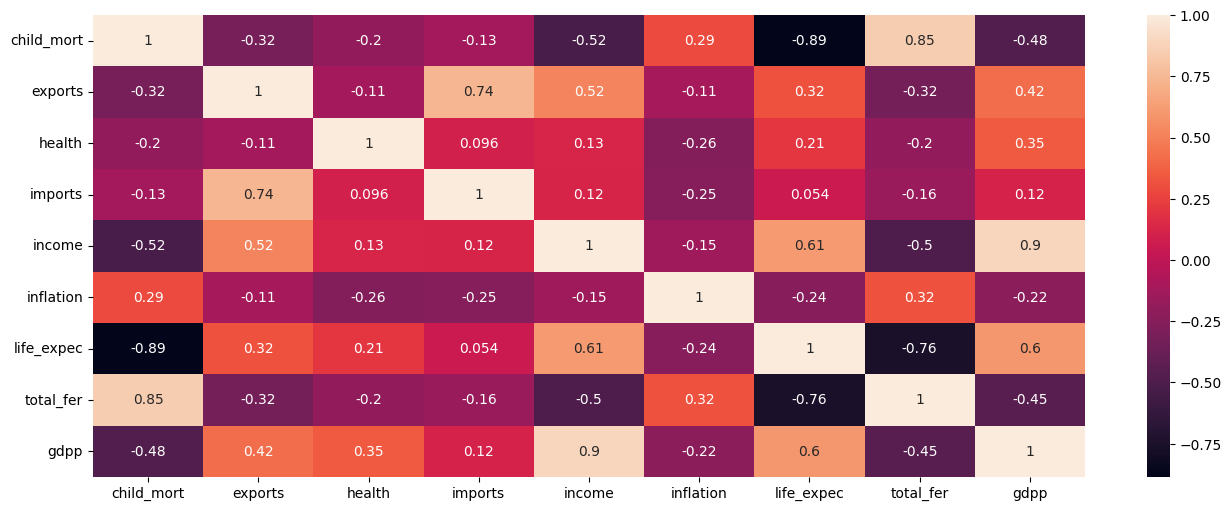

In [9]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap

df.corr()

plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), annot=True);

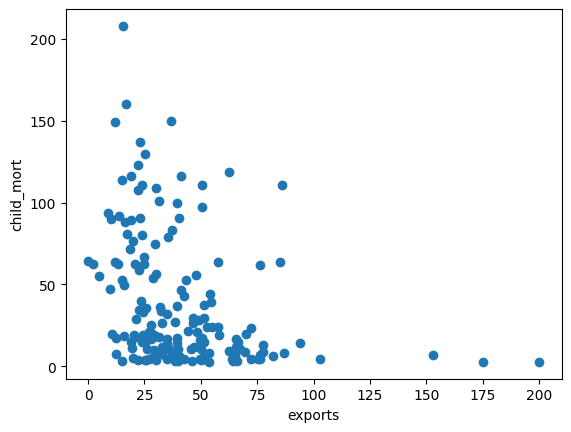

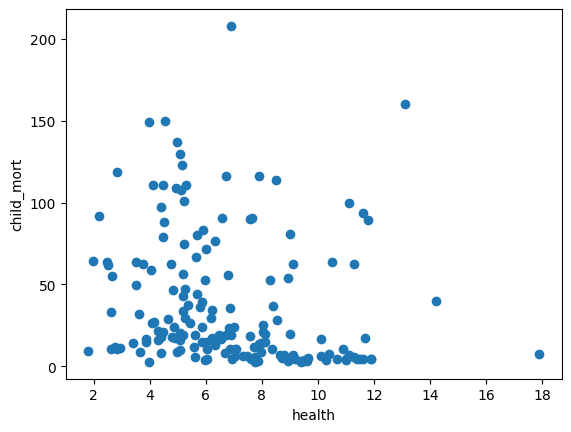

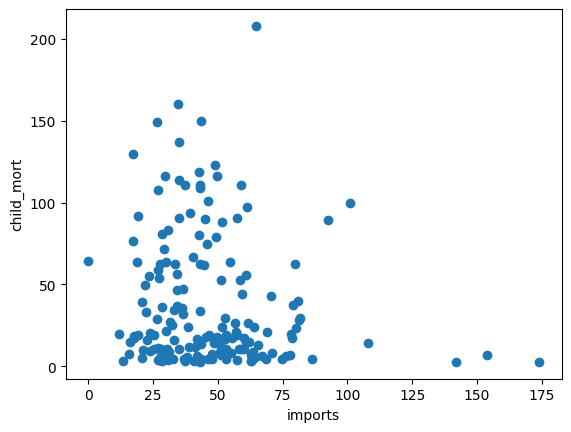

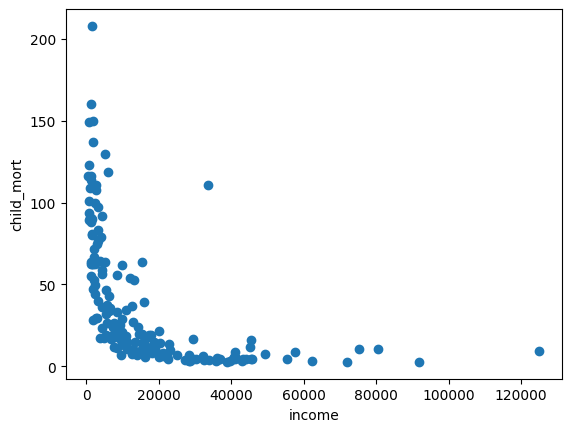

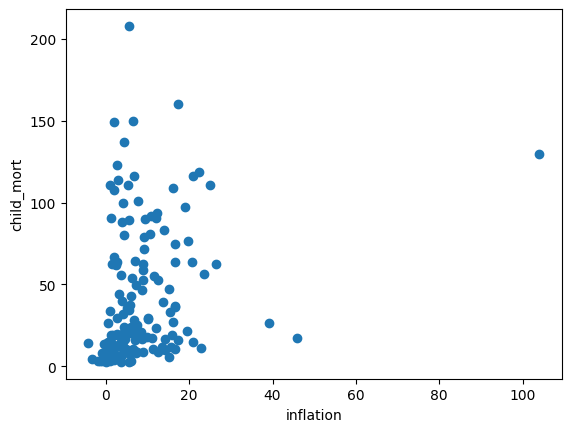

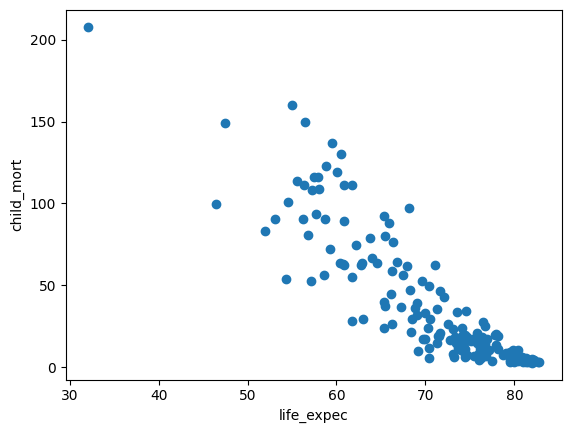

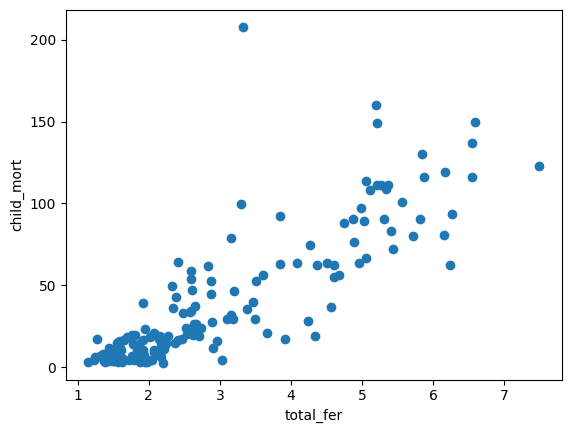

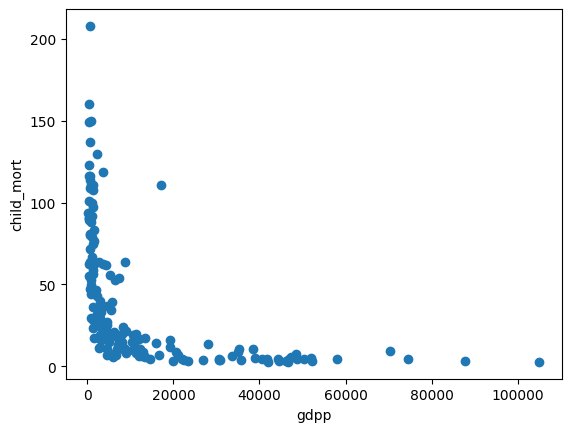

In [10]:
# Explore the continuous independent features against child_mort using scatter plots.

for f in df.columns[1:9]:
  plt.scatter(df[f], df['child_mort'])
  plt.xlabel(f)
  plt.ylabel('child_mort')
  plt.show()

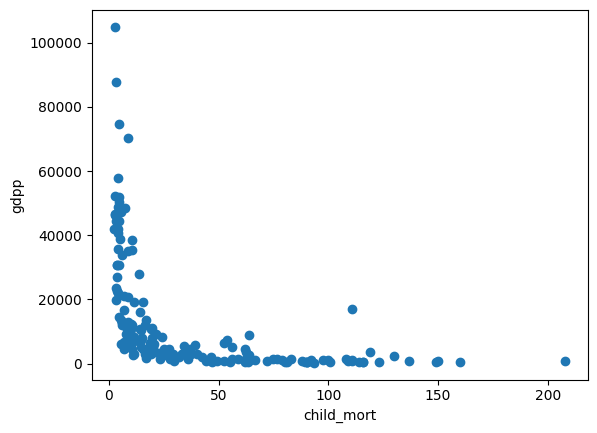

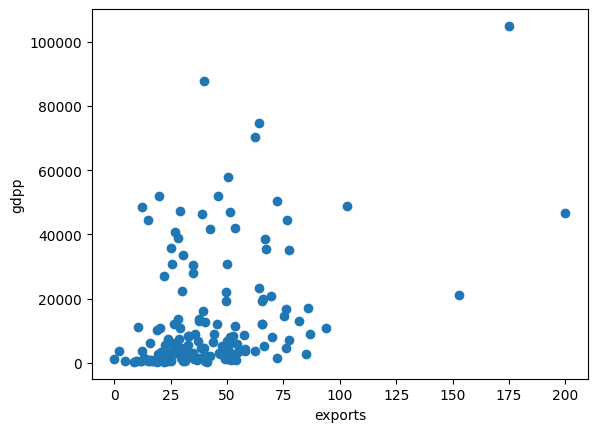

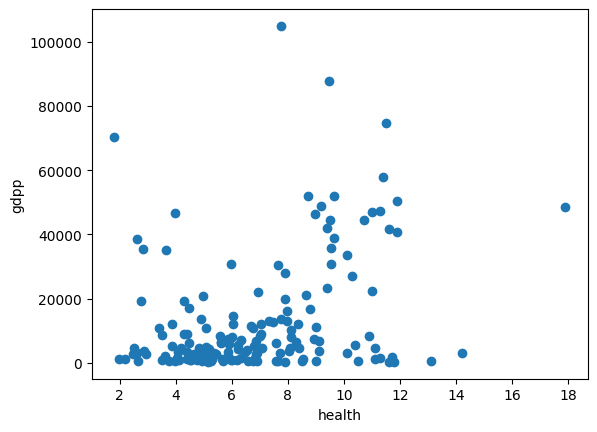

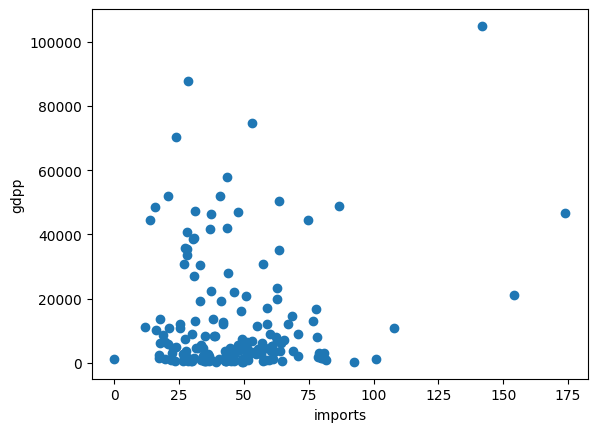

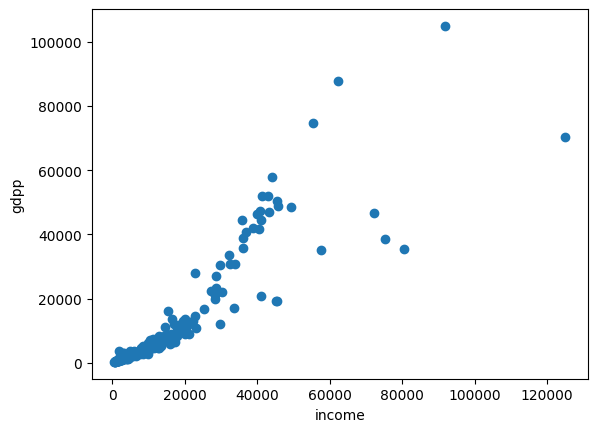

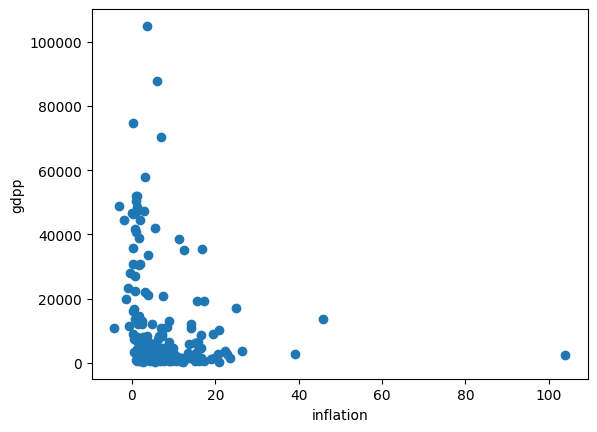

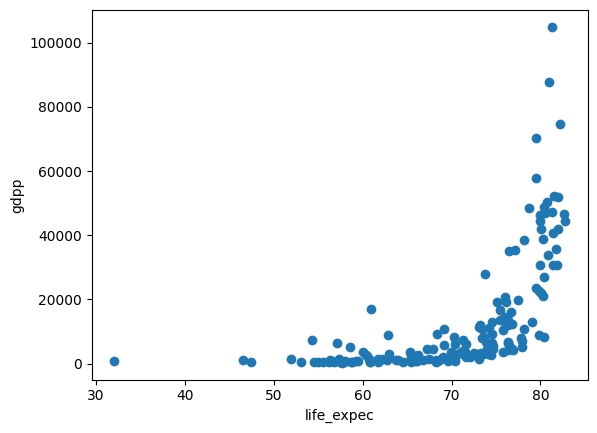

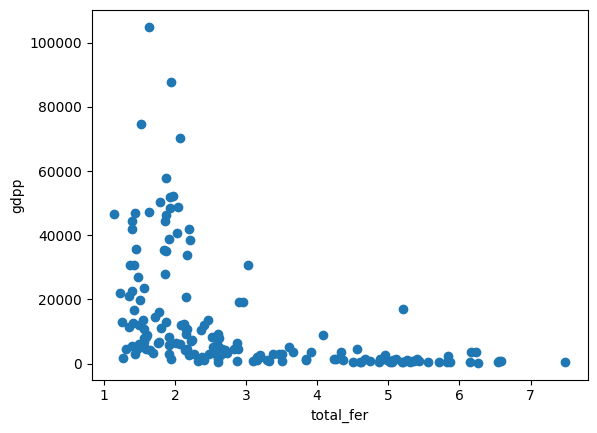

In [11]:
# Explore the continuous independent features against gdpp using scatter plots.
for f in df.columns[0:8]:
  plt.scatter(df[f], df['gdpp'])
  plt.xlabel(f)
  plt.ylabel('gdpp')
  plt.show()

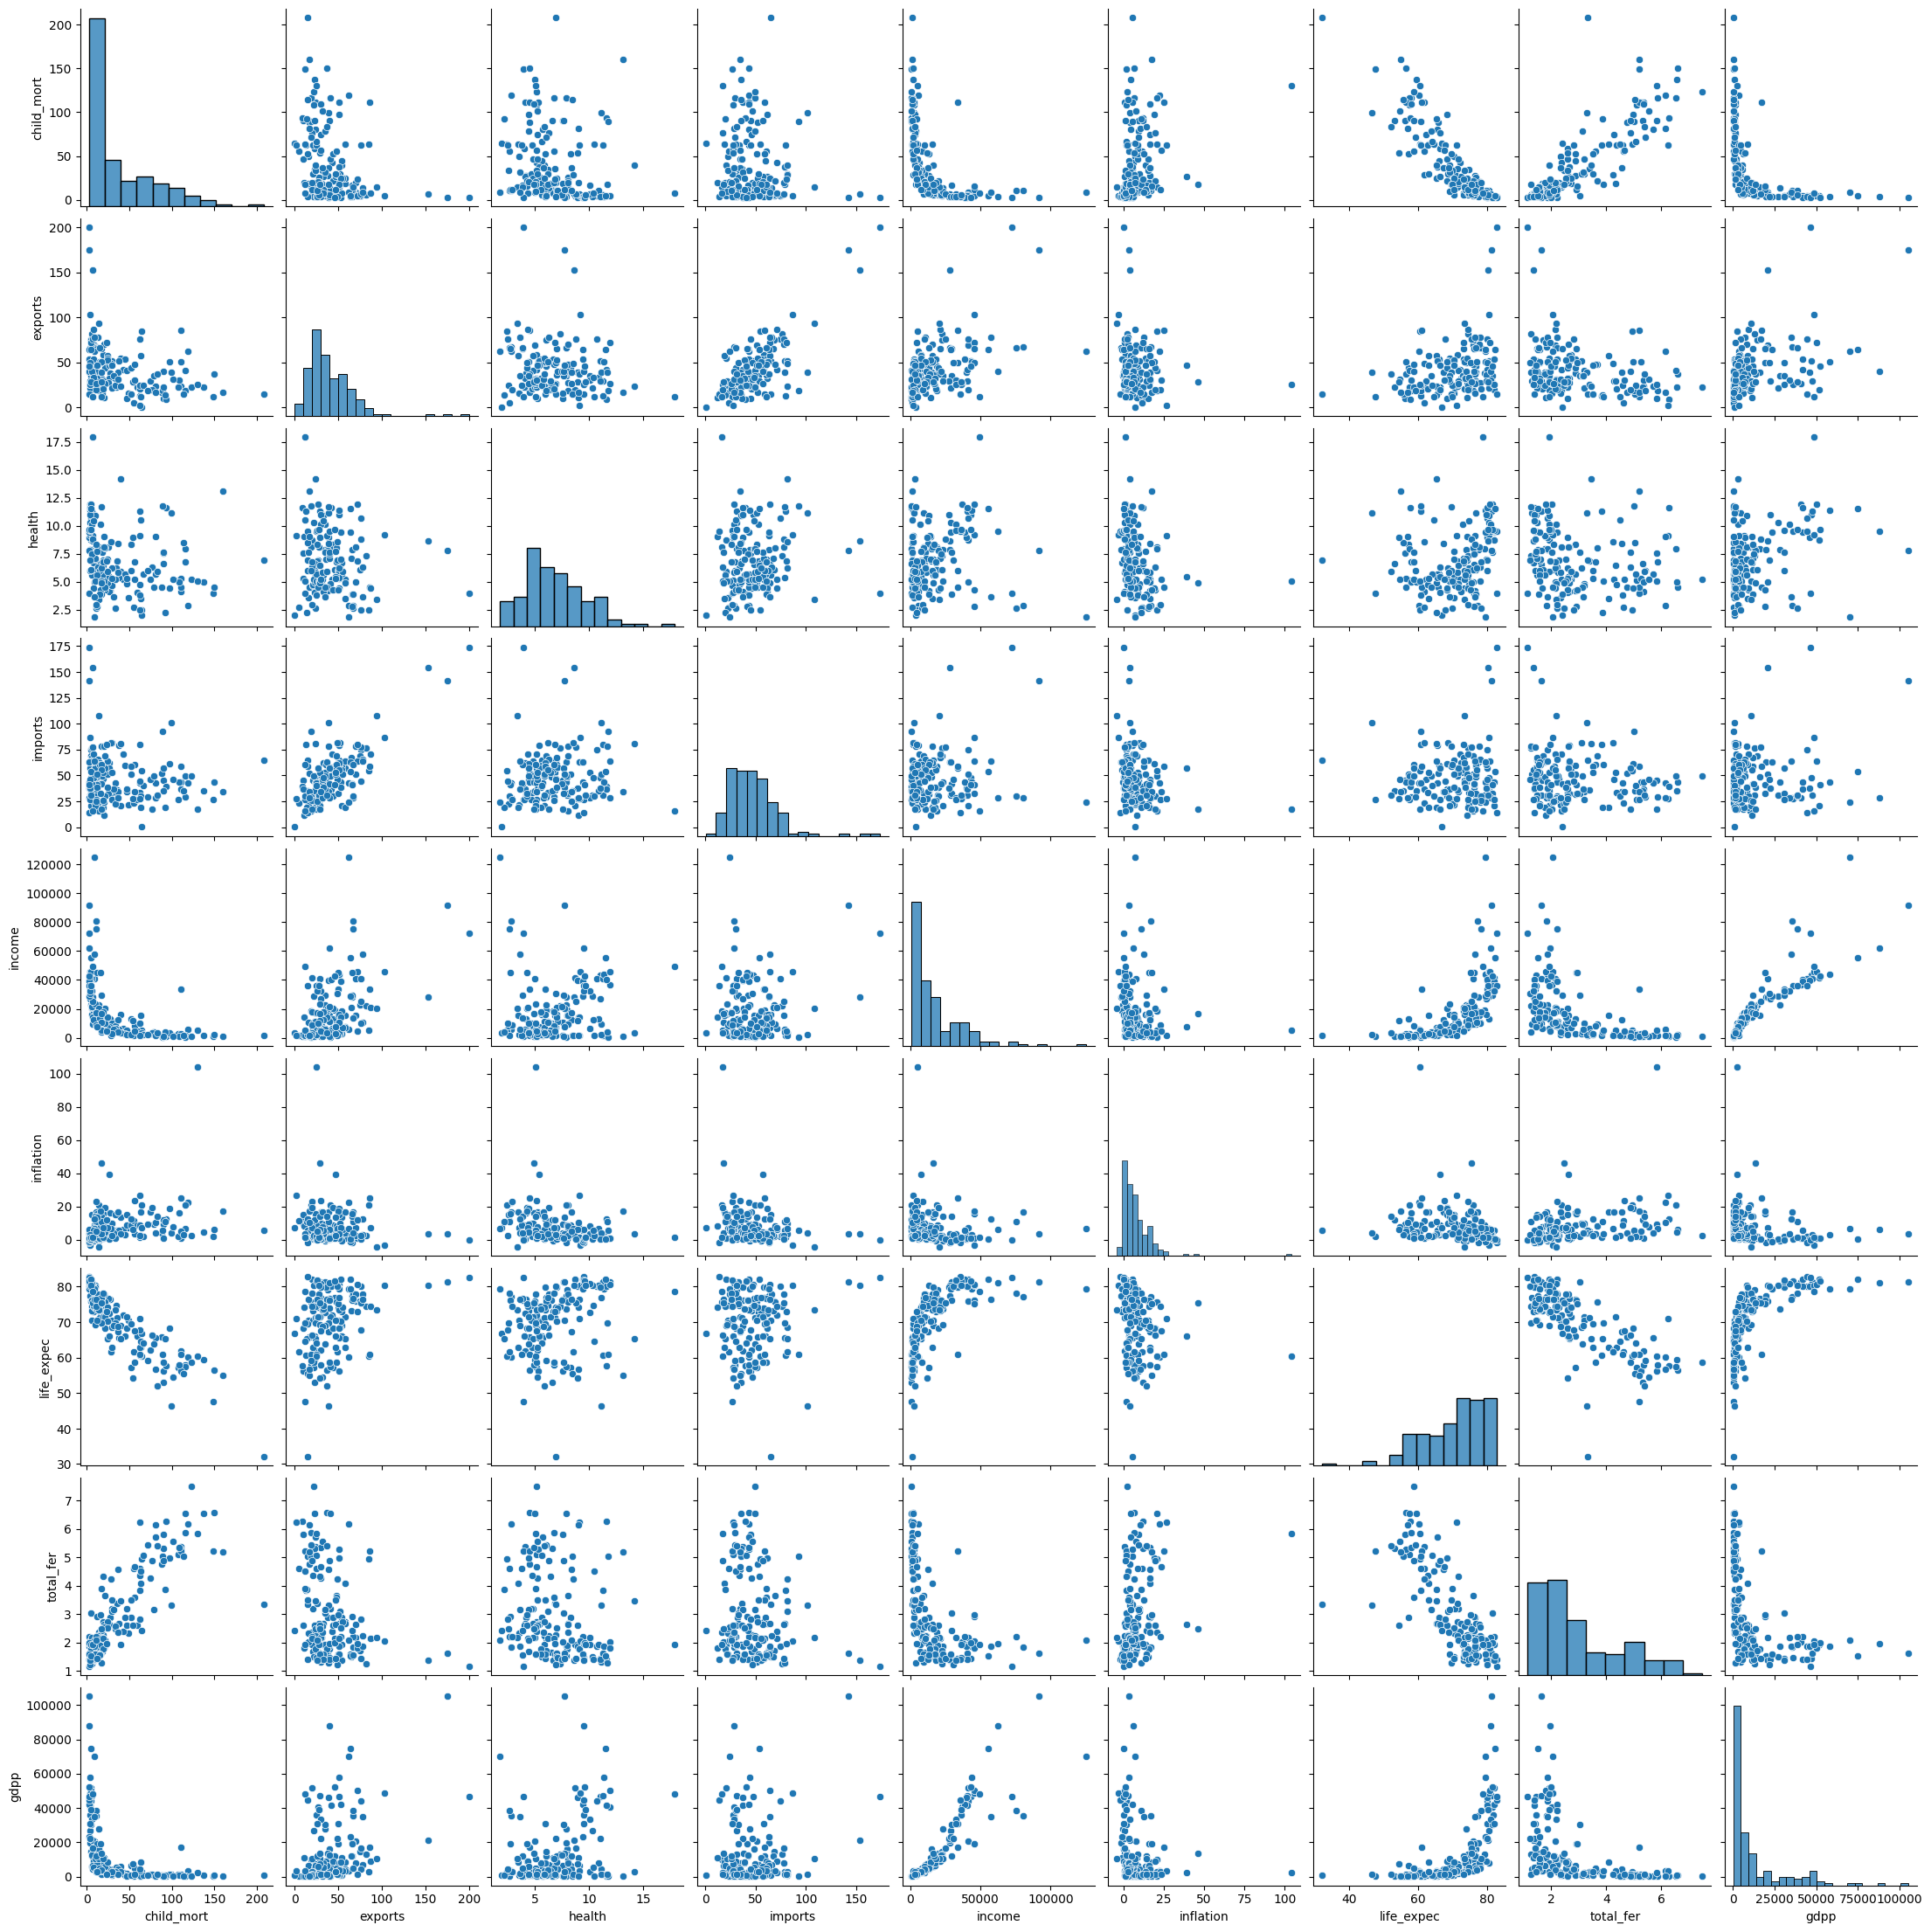

In [12]:
# Create a pair plot
# Hint: Explore seaborn pairplot

sns.pairplot(data=df)

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [13]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

mms = MinMaxScaler()

df_scaled = pd.DataFrame(mms.fit_transform(df.values), columns = df.columns, index=df.index)

# df_scaled.head()
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

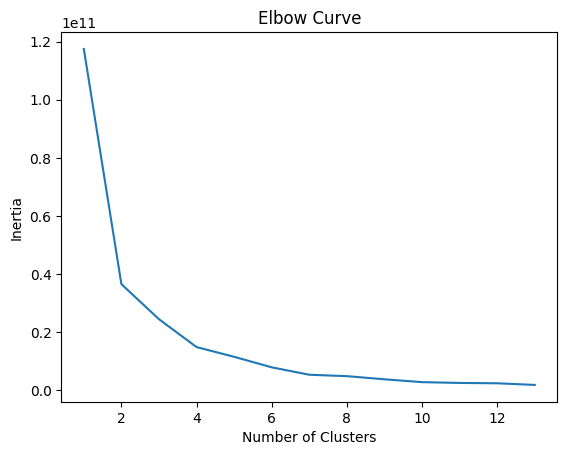

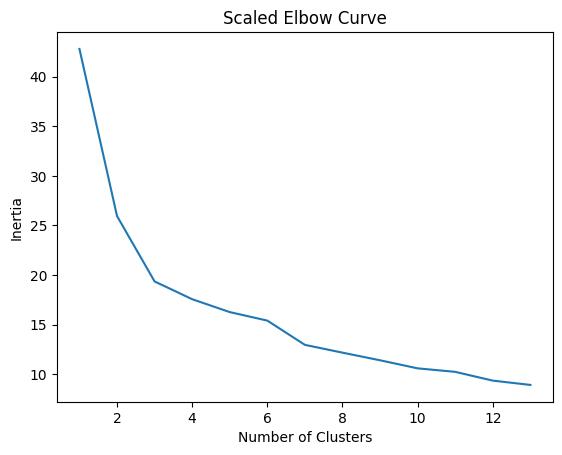

In [14]:
# Plot elbow curve
iner = []

for i in range(1,14): 
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df)
    iner.append(kmeans.inertia_)

plt.plot(range(1,14), iner)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


    # Plot elbow curve using scaled dataset

iner_scaled = []

for i in range(1,14): 
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df_scaled)
    iner_scaled.append(kmeans.inertia_)

plt.plot(range(1,14), iner_scaled)
plt.title('Scaled Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


The elbow plots suggests K value of between 2 and 8

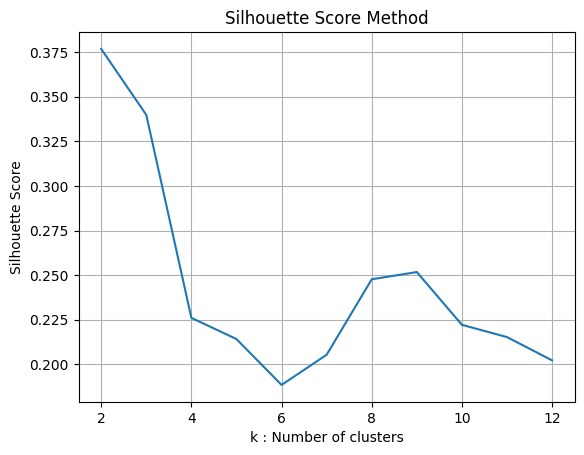

Silhouette Score = 0.20225387493215083


In [15]:
# Silhouette score method
kmax = 12
sil = []
plt.plot()
for k in range (2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

labels = kmeans.labels_
sscore = silhouette_score(df_scaled,labels)
print('Silhouette Score =', sscore)

## Fitting a K-Means Model with the selected K value

### Based on the elbow and silhouette score method choose a value for K.
Elbow suggested K value between 2 as this is the point of first curve and 7 as the drop off of the curve <br>
Silhouette also suggests 2 as this is the highest points on the graph <br>
Silhouette scores ideally are closer to 1

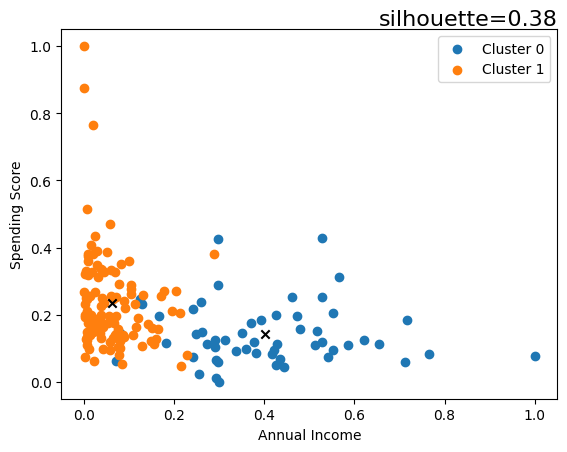

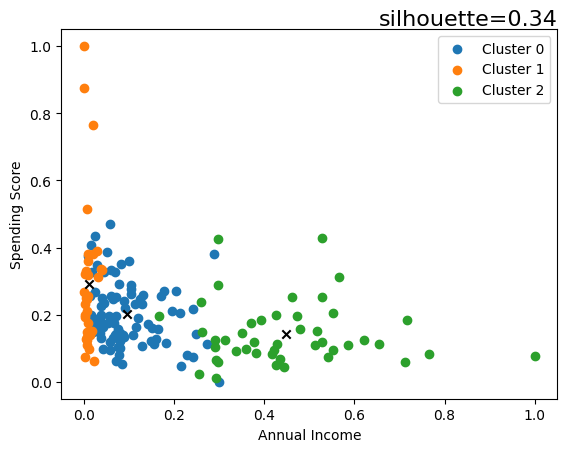

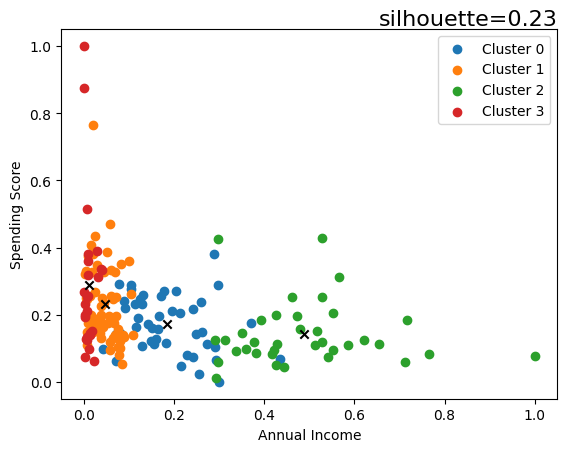

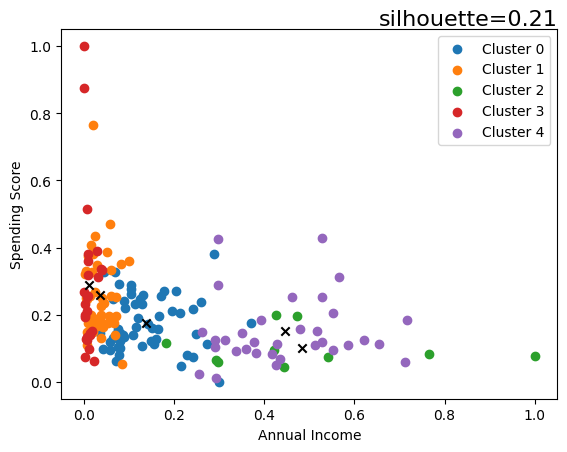

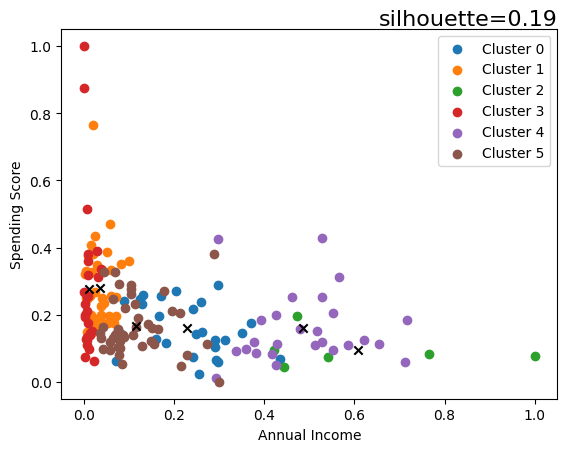

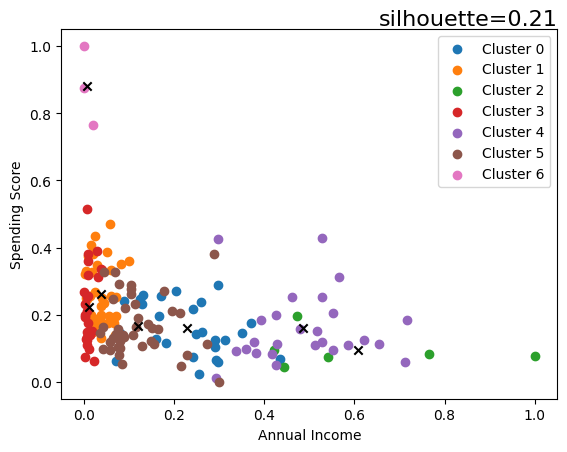

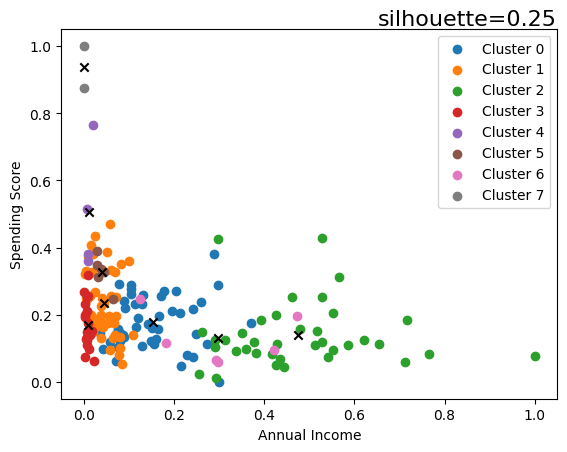

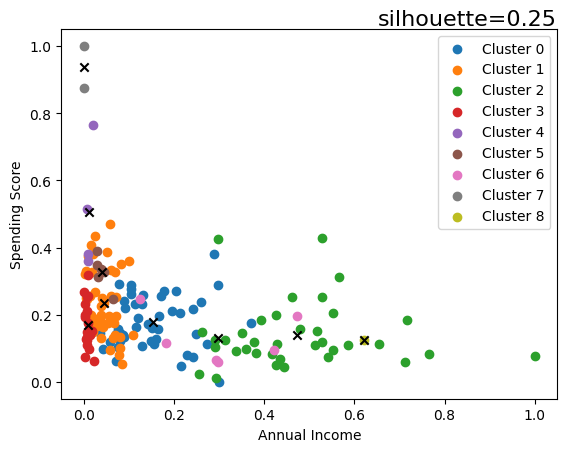

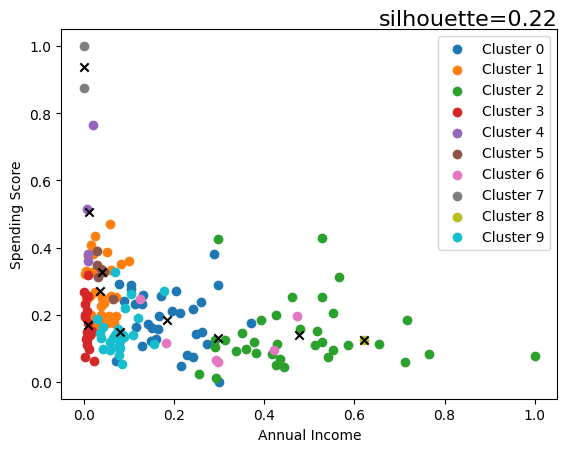

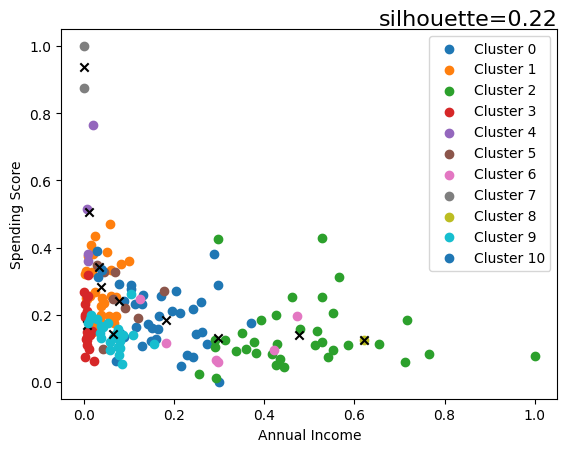

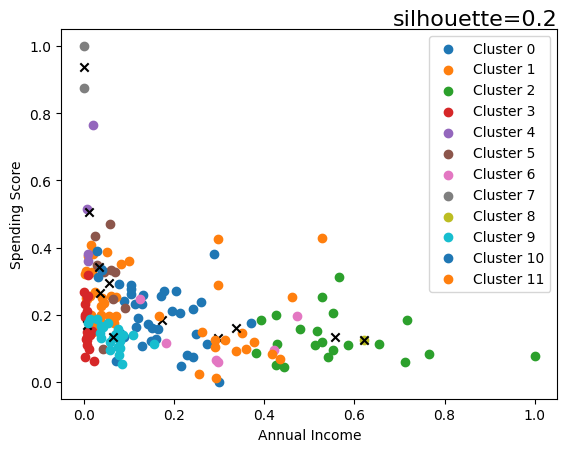

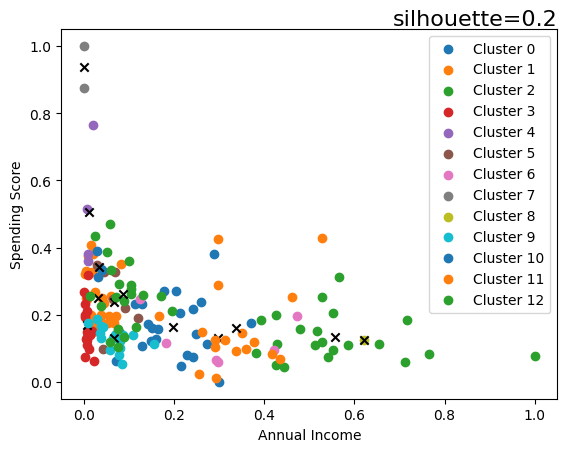

In [16]:
X = df_scaled[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']].values.reshape(-1,9)  

def scatter_Kmeans(x, k, r=rseed):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=rseed)
    y_pred = kmeans.fit_predict(x)
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'), 2)

    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.legend()
    plt.show()

for k in range(2,14):
  scatter_Kmeans(X, k, r=0)

In [17]:
# Count the number of records in each cluster

# K = 2 is best fit
kmeans = KMeans(n_clusters = 2, random_state = rseed)
kmeans.fit(df_scaled)

labels = kmeans.labels_
score = silhouette_score(df, labels)
score # a value close to 1 is good

0.11712129595026219

In [18]:
# Check model performance with the silhouette coefficient

In [19]:
fkmeans = KMeans(n_clusters =2, random_state = rseed)
fkmeans.fit(df_scaled)

labels = fkmeans.labels_
fsscore = silhouette_score(df_scaled,labels)
print('Silhouette Score =', fsscore)

Silhouette Score = 0.37671430588173554


## Predictions

In [25]:
# Add the predicted cluster label column to the original dataframe

df_scaled['Cluster'] = labels
df_scaled.head()
     



,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,0
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,1
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,1
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,0
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,1


## Visualisation of clusters

<Axes: xlabel='child_mort', ylabel='gdpp'>

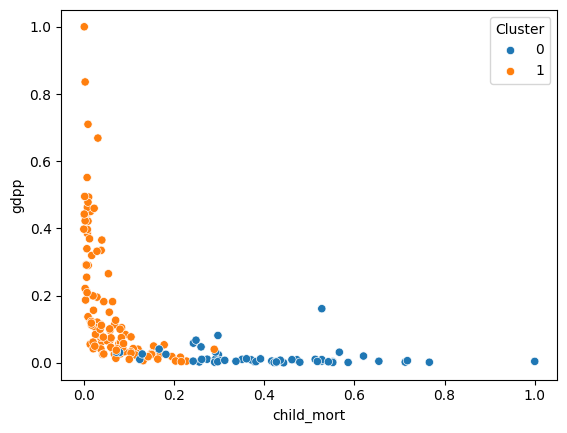

In [26]:
# Visualisation of clusters: child mortality vs gdpp

sns.scatterplot(x = df_scaled['child_mort'], y = df_scaled['gdpp'], hue = df_scaled['Cluster'])

<Axes: xlabel='inflation', ylabel='gdpp'>

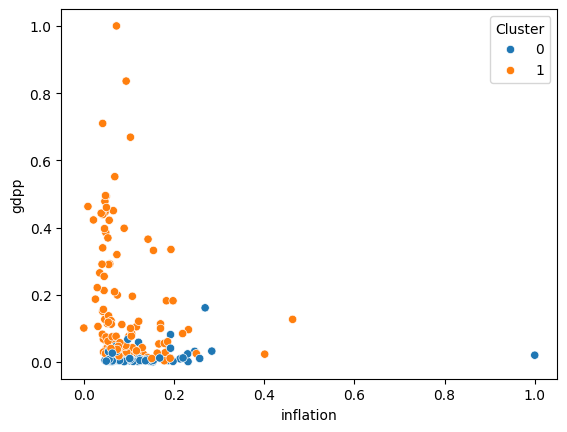

In [27]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(x = df_scaled['inflation'], y = df_scaled['gdpp'], hue = df_scaled['Cluster'])

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**
<br> Cluster 0 = least developed
<br> Cluster 1 = most developed